In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).parent))

In [3]:
import math
import time

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

import pytorch_lightning as pl
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from gan.vanilla import VanillaGAN
from gan.callbacks import ImageGenerationCallback
from utils import show_imgs

DATASET_PATH = Path(os.getcwd()).parent / "data"
MODELS_DIR = DATASET_PATH / "saved_models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", DEVICE)

Seed set to 42


Using device cuda:0


In [4]:
BATCH_SIZE = 8192
NUM_WORKERS = 16

MAX_EPOCHS = 1000
LATENT_DIM = 128
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-5

In [5]:
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=NUM_WORKERS, persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, persistent_workers=True)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, persistent_workers=True)

In [6]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
torch.min(train_dataset[0][0]), torch.max(train_dataset[0][0])

(tensor(-1.), tensor(1.))

In [8]:
def train_gan(
    epochs: int = 50,
    latent_dim: int = 128,
    lr: float = 2e-4,
    img_callback_every_n_epochs: int = 50
):
    
    # Initialize model
    model = VanillaGAN(
        latent_dim=latent_dim,
        img_shape=(1, 28, 28),
        lr=lr
    )
    default_root_dir=MODELS_DIR / f"mnist_vanilla_gan_{latent_dim}"
    samples_dir = default_root_dir / "samples"
    samples_dir.mkdir(parents=True, exist_ok=True)
    # Initialize callback for image generation
    img_callback = ImageGenerationCallback(
        output_dir=str(default_root_dir / "samples"),
        every_n_epochs=img_callback_every_n_epochs
    )
    # Initialize trainer
    trainer = pl.Trainer(
        default_root_dir=default_root_dir,
        max_epochs=epochs,
        accelerator="gpu" if str(DEVICE).startswith("cuda") else "cpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, save_last=True),
            LearningRateMonitor("epoch"),
            img_callback,
        ],
        enable_progress_bar=True,
        log_every_n_steps=50,
    )
    
    # Train the model
    trainer.fit(model, train_loader, val_loader)
    
    return model, img_callback

In [9]:
vanilla_gan_model, img_callback = train_gan(
    epochs=MAX_EPOCHS,
    latent_dim=LATENT_DIM,
    lr=LEARNING_RATE,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/xgeoadmin/miniconda3/envs/cuda-ml/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 5090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type          | Params | Mode 
-----------------------------------------------------------
0 | generator        | Generator     | 1.5 M  | train
1 | discriminator    | Discriminator | 533 K  | train
2 | adversarial_loss | BCELoss       | 0      | train
-----------------------------------------------------------
2.0 M     Trainable params
0         Non-trainab

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [10]:
import numpy as np

def plot_losses(g_losses: list, d_losses: list):
    """Plot generator and discriminator losses over training."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Smooth losses for better visualization
    window = min(100, len(g_losses) // 10) if len(g_losses) > 100 else 1
    
    def smooth(losses, window):
        if window <= 1:
            return losses
        return np.convolve(losses, np.ones(window)/window, mode='valid')
    
    g_smooth = smooth(g_losses, window)
    d_smooth = smooth(d_losses, window)
    
    # Plot raw losses
    axes[0].plot(g_losses, alpha=0.3, label='Generator (raw)', color='blue')
    axes[0].plot(d_losses, alpha=0.3, label='Discriminator (raw)', color='orange')
    axes[0].plot(range(window-1, len(g_losses)), g_smooth, label='Generator (smoothed)', color='blue', linewidth=2)
    axes[0].plot(range(window-1, len(d_losses)), d_smooth, label='Discriminator (smoothed)', color='orange', linewidth=2)
    axes[0].set_xlabel('Training Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Generator vs Discriminator Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot loss ratio (stability indicator)
    ratio = np.array(g_losses) / (np.array(d_losses) + 1e-8)
    ratio_smooth = smooth(ratio, window)
    axes[1].plot(ratio, alpha=0.3, label='G/D Loss Ratio (raw)', color='green')
    axes[1].plot(range(window-1, len(ratio)), ratio_smooth, label='G/D Loss Ratio (smoothed)', color='green', linewidth=2)
    axes[1].axhline(y=1.0, color='red', linestyle='--', label='Ideal ratio = 1')
    axes[1].set_xlabel('Training Steps')
    axes[1].set_ylabel('Loss Ratio (G/D)')
    axes[1].set_title('Training Stability (G/D Loss Ratio)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, max(5, np.percentile(ratio, 95))])
    
    plt.tight_layout()
    # plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    # print(f"Loss plot saved to {output_path}")

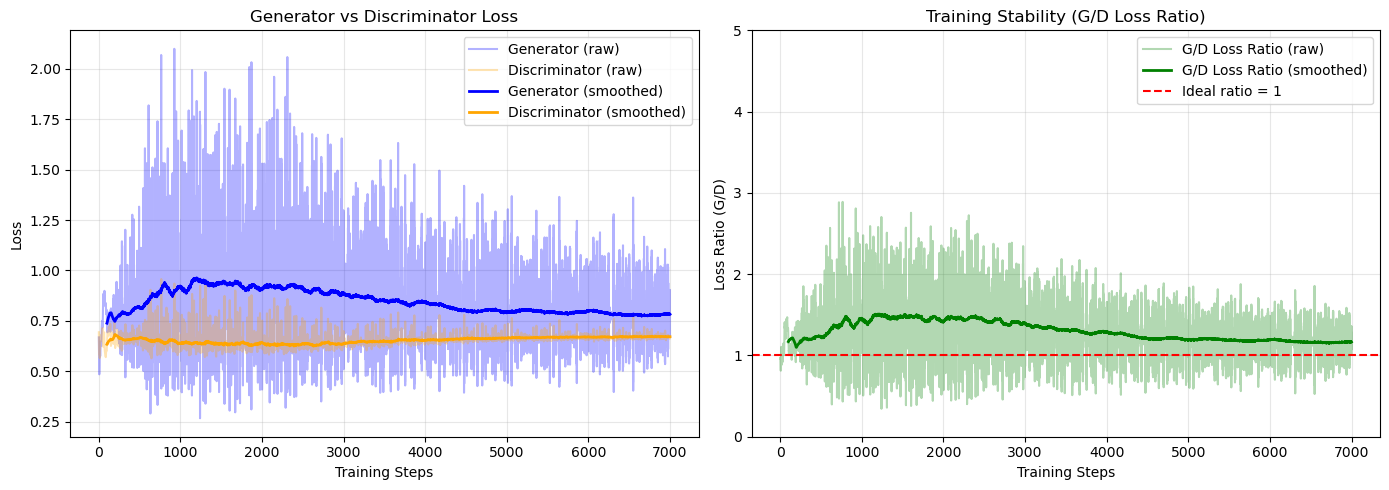

In [11]:
plot_losses(
    vanilla_gan_model.g_losses,
    vanilla_gan_model.d_losses,
)

In [12]:
from torchvision.utils import make_grid

def analyze_mode_collapse(callback: ImageGenerationCallback):
    """
    Analyze generated images for signs of mode collapse.
    Mode collapse occurs when the generator produces limited variety of outputs.
    """
    if len(callback.generated_images) < 2:
        print("Not enough epochs to analyze mode collapse")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Show progression of generated images
    epochs_to_show = [0, len(callback.generated_images)//2, len(callback.generated_images)-1]
    
    for idx, epoch_idx in enumerate(epochs_to_show):
        epoch, imgs = callback.generated_images[epoch_idx]
        grid = make_grid(imgs[:16], nrow=4, normalize=True, value_range=(-1, 1))
        axes[0, idx].imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
        axes[0, idx].set_title(f'Epoch {epoch + 1}')
        axes[0, idx].axis('off')
    
    # Compute diversity metrics
    diversities = []
    for epoch, imgs in callback.generated_images:
        # Flatten images and compute pairwise distances
        flat_imgs = imgs.view(imgs.size(0), -1)
        
        # Compute mean pairwise L2 distance
        dists = torch.cdist(flat_imgs, flat_imgs)
        # Get upper triangle (excluding diagonal)
        mask = torch.triu(torch.ones_like(dists), diagonal=1).bool()
        mean_dist = dists[mask].mean().item()
        
        # Compute standard deviation of pixels across batch
        pixel_std = flat_imgs.std(dim=0).mean().item()
        
        diversities.append({
            'epoch': epoch,
            'mean_pairwise_dist': mean_dist,
            'pixel_std': pixel_std
        })
    
    epochs = [d['epoch'] for d in diversities]
    pairwise_dists = [d['mean_pairwise_dist'] for d in diversities]
    pixel_stds = [d['pixel_std'] for d in diversities]
    
    # Plot diversity metrics
    axes[1, 0].plot(epochs, pairwise_dists, 'b-o', linewidth=2, markersize=6)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Mean Pairwise Distance')
    axes[1, 0].set_title('Image Diversity (Pairwise Distance)')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(epochs, pixel_stds, 'g-o', linewidth=2, markersize=6)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Pixel Std Dev')
    axes[1, 1].set_title('Image Diversity (Pixel Variation)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Mode collapse warning
    final_diversity = pairwise_dists[-1]
    initial_diversity = pairwise_dists[0] if pairwise_dists[0] > 0 else 1
    diversity_ratio = final_diversity / initial_diversity
    
    warning_text = ""
    if diversity_ratio < 0.5:
        warning_text = "⚠️ POSSIBLE MODE COLLAPSE DETECTED!\nDiversity decreased significantly."
        color = 'red'
    elif diversity_ratio < 0.8:
        warning_text = "⚠️ Warning: Diversity decreasing.\nMonitor for mode collapse."
        color = 'orange'
    else:
        warning_text = "✓ Diversity maintained.\nNo obvious mode collapse."
        color = 'green'
    
    axes[1, 2].text(0.5, 0.5, warning_text, ha='center', va='center',
                    fontsize=14, color=color, transform=axes[1, 2].transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor=color))
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Mode Collapse Analysis')
    
    plt.suptitle('Mode Collapse Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

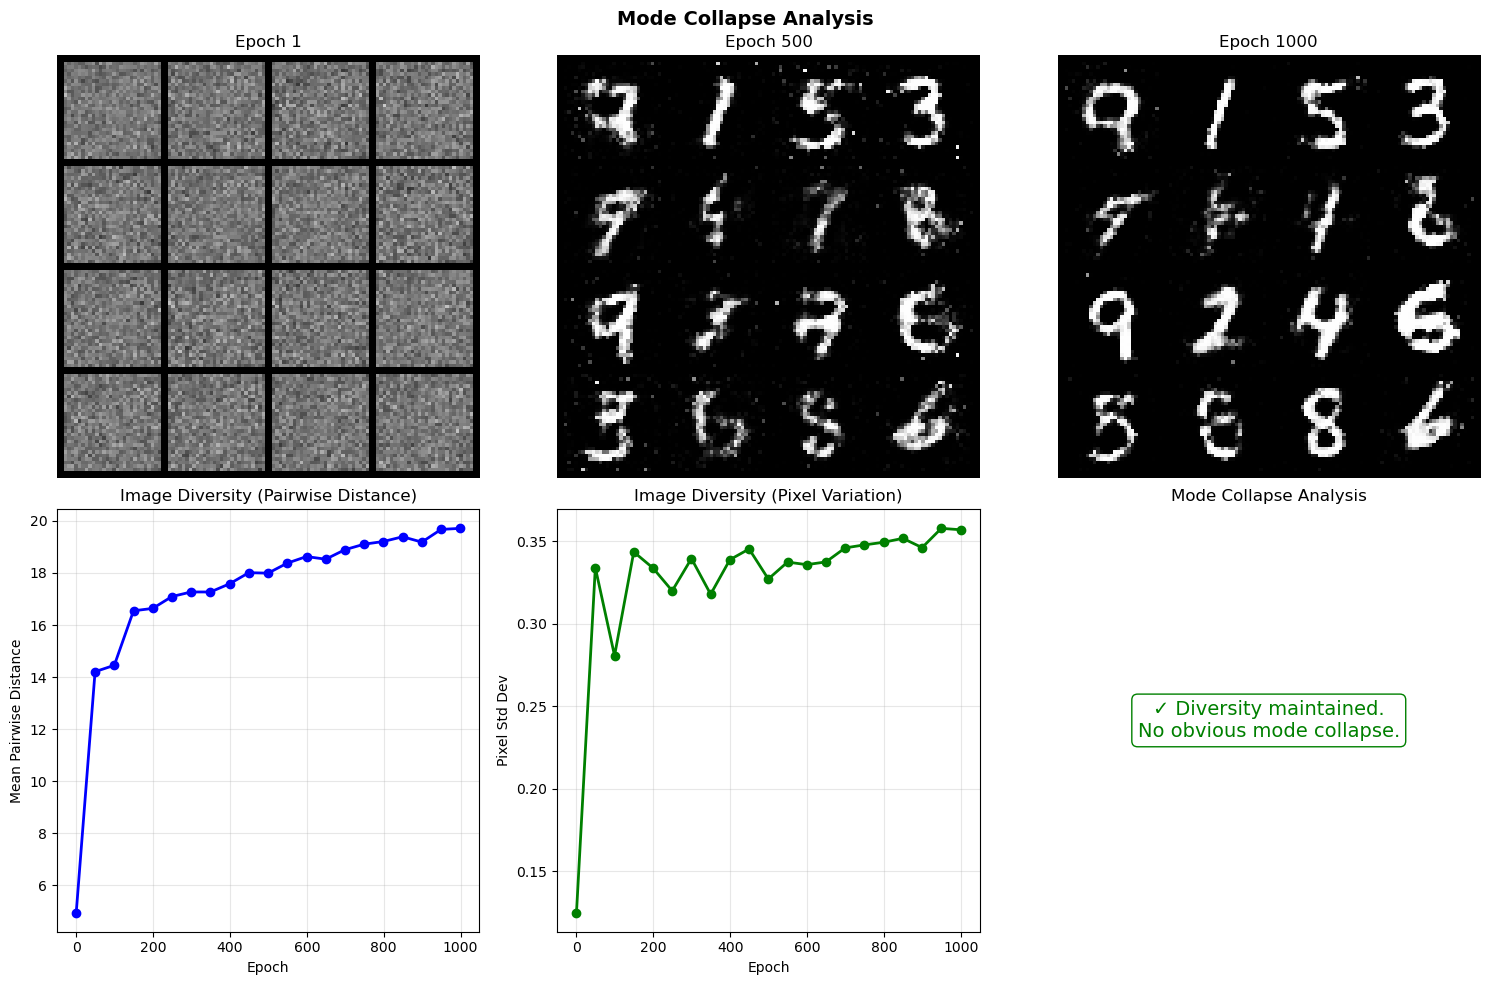

In [13]:
analyze_mode_collapse(img_callback)

In [14]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

def visualize_real_vs_fake(model: VanillaGAN, dataloader: DataLoader):
    """Compare real images with generated fake images."""
    # Get real images
    real_imgs, _ = next(iter(dataloader))
    real_imgs = real_imgs[:32]
    
    # Generate fake images
    model.eval()
    with torch.no_grad():
        z = torch.randn(32, model.hparams.latent_dim, device=model.device)
        fake_imgs = model(z).cpu()
    model.train()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Real images
    real_grid = make_grid(real_imgs, nrow=8, normalize=True, value_range=(-1, 1))
    axes[0].imshow(real_grid.permute(1, 2, 0).numpy(), cmap='gray')
    axes[0].set_title('Real Images', fontsize=14)
    axes[0].axis('off')
    
    # Fake images
    fake_grid = make_grid(fake_imgs, nrow=8, normalize=True, value_range=(-1, 1))
    axes[1].imshow(fake_grid.permute(1, 2, 0).numpy(), cmap='gray')
    axes[1].set_title('Generated (Fake) Images', fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    # plt.savefig(output_path, dpi=150, bbox_inches='tight')
    # plt.close()
    plt.show()
    # print(f"Real vs Fake comparison saved to {output_path}")

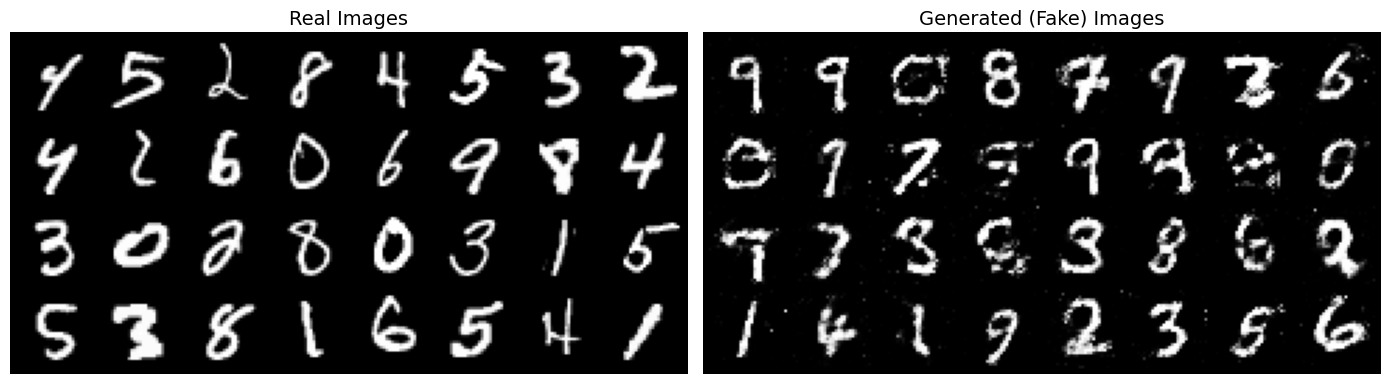

In [15]:
visualize_real_vs_fake(model=vanilla_gan_model, dataloader=val_loader)